## DATASCI 415 Project: Backcasting and Forecasting Energy Demand
### Mary Du, Sandra Warida

In [1]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#### Exploring the Data

In [2]:
# Loading the datasets
load_hist = pd.read_csv('Load_history.csv')
temp_hist = pd.read_csv('temperature_history.csv')
solution = pd.read_csv('Load_solution.csv')

# Renaming columns and converting values to numeric
temp_hist = temp_hist.rename(columns={f'h{i}': f'temp_h{i}' for i in range(1, 25)})
load_hist.loc[:, 'h1':'h24'] = load_hist.loc[:, 'h1':'h24'].replace({',': ''}, regex=True).apply(pd.to_numeric, errors='coerce')


In [ ]:
# Creating numerical summaries
sum_load = load_hist.describe()
sum_temp = temp_hist.describe()
print(f"Summary of Load History \n {sum_load}")
print(f"Summary of Temp History \n {sum_temp}")

Summary of Load History 
             zone_id          year         month           day
count  33000.000000  33000.000000  33000.000000  33000.000000
mean      10.500000   2005.785455      6.191515     15.673939
std        5.766369      1.319811      3.428231      8.811922
min        1.000000   2004.000000      1.000000      1.000000
25%        5.750000   2005.000000      3.000000      8.000000
50%       10.500000   2006.000000      6.000000     16.000000
75%       15.250000   2007.000000      9.000000     23.000000
max       20.000000   2008.000000     12.000000     31.000000
Summary of Temp History 
          station_id          year         month           day       temp_h1  \
count  18073.000000  18073.000000  18073.000000  18073.000000  18073.000000   
mean       6.000000   2005.776019      6.188071     15.723676     52.826924   
std        3.162365      1.314680      3.435162      8.796737     15.706729   
min        1.000000   2004.000000      1.000000      1.000000      3.00000

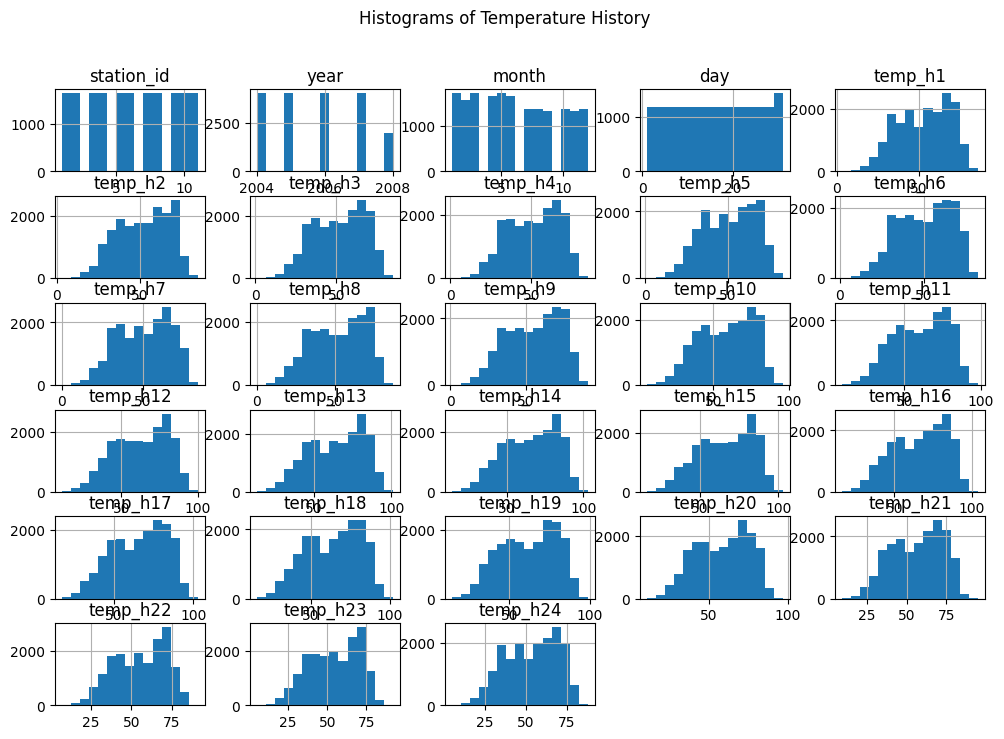

In [ ]:
# Creating graphical summaries

# Histogram of Temperature History
temp_hist.hist(bins=15, figsize=(12, 8))
plt.suptitle('Histograms of Temperature History')
plt.show()

#### Cleaning the data

In [3]:
# Removing rows with missing values
load_hist.dropna(inplace=True)
temp_hist.dropna(inplace=True)

#### Preprocessing the data

In [4]:
# Calculating MSE of each station for all zones to find a suitable mapping between load and temperature data
def evaluate_station(load_data, temp_data, station_id):
    merged_data = load_data.merge(temp_data[temp_data['station_id'] == station_id],
                                   on=['year', 'month', 'day'], how='left')
    merged_data.dropna(inplace=True)

    X = merged_data[['zone_id', 'year', 'month', 'day'] + [f'temp_h{i}' for i in range(1, 25)]]
    y = merged_data[[f'h{i}' for i in range(1, 25)]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = MultiOutputRegressor(LinearRegression())
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)

    return mse


best_stations = {}

for zone_id in load_hist['zone_id'].unique():
    zone_data = load_hist[load_hist['zone_id'] == zone_id]
    best_mse = float('inf')
    best_station = None

    for station_id in temp_hist['station_id'].unique():
        mse = evaluate_station(zone_data, temp_hist, station_id)
        if mse < best_mse:
            best_mse = mse
            best_station = station_id

    best_stations[zone_id] = best_station

print(best_stations)

{1: 10, 2: 10, 3: 10, 4: 2, 5: 10, 6: 10, 7: 10, 8: 11, 9: 3, 10: 1, 11: 1, 12: 1, 13: 10, 14: 1, 15: 1, 16: 1, 17: 10, 18: 10, 19: 10, 20: 10}


In [5]:
# Merging load and temperature data based on mapping between zone and station
mapping_df = pd.DataFrame(list(best_stations.items()), columns=['zone_id', 'station_id'])
load_hist_with_stations = load_hist.merge(mapping_df, on='zone_id', how='left')

final_data = load_hist_with_stations.merge(temp_hist,
                                            how='left',
                                            left_on=['year', 'month', 'day', 'station_id'],
                                            right_on=['year', 'month', 'day', 'station_id'])


# Merging for test weeks as well

# Step 1: Separate the data by weights (since forecasted weeks don't have temperature data available)
weights_1 = solution[solution['weight'] == 1]
weights_8 = solution[solution['weight'] == 8]
weights_20_160 = solution[solution['weight'].isin([20, 160])]

# Step 2: Merge temperature history for weights 1 (zonal backcasted)
weights_1_with_stations = weights_1.merge(mapping_df, on='zone_id', how='left')

weights_1_with_temp = weights_1_with_stations.merge(temp_hist,
                                            how='left',
                                            left_on=['year', 'month', 'day', 'station_id'],
                                            right_on=['year', 'month', 'day', 'station_id'])

# Step 3: For weights 8 (zonal forecasted), compute avg temp from same days in previous years
weights_8_with_temp = weights_8.merge(mapping_df, on='zone_id', how='left')

for i, row in weights_8_with_temp.iterrows():
    for hour in range(1, 25):
        hour_column = f'temp_h{hour}'
        same_day_previous_years = temp_hist[
            (temp_hist['station_id'] == row['station_id']) &
            (temp_hist['month'] == row['month']) &
            (temp_hist['day'] == row['day'])
        ]
        weights_8_with_temp.at[i, hour_column] = same_day_previous_years[hour_column].mean()

temperature_columns = [f'temp_h{i}' for i in range(1, 25)]

solution_new = pd.concat([weights_1_with_temp, weights_8_with_temp, weights_20_160])
solution_new.loc[solution_new['zone_id'] == 21, temperature_columns] = 0
solution_new.loc[solution_new['zone_id'] == 21, 'station_id'] = 0

final_data.to_csv("final_data.csv", index=False)

pd.DataFrame(solution_new).to_csv("solution_new.csv", index=True)

#### Multiple Linear Regression Model

In [6]:
# Multiple Linear Regression as a Baseline Model

# One-hot encoding categorical variables
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), ['zone_id', 'month', 'day'])
    ],
    remainder='passthrough'
)

# Loop through each unique zone and predict separately for more accurate results
zone_predictions = []

for zone_id in final_data['zone_id'].unique():
    final_data_zone = final_data[final_data['zone_id'] == zone_id]
    solution_zone = solution_new[solution_new['zone_id'] == zone_id]

    # Generate polynomial and interaction terms for train and test data for the current zone
    for i in range(1, 25):
        final_data_zone[f'temp_h{i}_squared'] = final_data_zone[f'temp_h{i}'] ** 2
        final_data_zone[f'temp_h{i}_cubed'] = final_data_zone[f'temp_h{i}'] ** 3
        final_data_zone[f'temp_h{i}_day'] = final_data_zone[f'temp_h{i}'] * final_data_zone['day']
        final_data_zone[f'temp_h{i}_month'] = final_data_zone[f'temp_h{i}'] * final_data_zone['month']
        final_data_zone[f'temp_h{i}_hour'] = final_data_zone[f'temp_h{i}'] * i
        final_data_zone[f'temp_h{i}_squared_month'] = final_data_zone[f'temp_h{i}_squared'] * final_data_zone['month']
        final_data_zone[f'temp_h{i}_cubed_hour'] = final_data_zone[f'temp_h{i}_cubed'] * i

        solution_zone[f'temp_h{i}_squared'] = solution_zone[f'temp_h{i}'] ** 2
        solution_zone[f'temp_h{i}_cubed'] = solution_zone[f'temp_h{i}'] ** 3
        solution_zone[f'temp_h{i}_day'] = solution_zone[f'temp_h{i}'] * solution_zone['day']
        solution_zone[f'temp_h{i}_month'] = solution_zone[f'temp_h{i}'] * solution_zone['month']
        solution_zone[f'temp_h{i}_hour'] = solution_zone[f'temp_h{i}'] * i
        solution_zone[f'temp_h{i}_squared_month'] = solution_zone[f'temp_h{i}_squared'] * solution_zone['month']
        solution_zone[f'temp_h{i}_cubed_hour'] = solution_zone[f'temp_h{i}_cubed'] * i

    # Prepare training and testing datasets
    Xtrain_zone = column_transformer.fit_transform(final_data_zone[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                                    [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_cubed' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_day' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_month' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_hour' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_squared_month' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_cubed_hour' for i in range(1, 25)]])

    Ytrain_zone = final_data_zone[['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
                                   'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
                                   'h19', 'h20', 'h21', 'h22', 'h23', 'h24']]

    Xtest_zone = column_transformer.transform(solution_zone[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                           [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                           [f'temp_h{i}_cubed' for i in range(1, 25)] +
                                                           [f'temp_h{i}_day' for i in range(1, 25)] +
                                                           [f'temp_h{i}_month' for i in range(1, 25)] +
                                                           [f'temp_h{i}_hour' for i in range(1, 25)] +
                                                           [f'temp_h{i}_squared_month' for i in range(1, 25)] +
                                                           [f'temp_h{i}_cubed_hour' for i in range(1, 25)]])
    # Fit the model and predict on test data
    model = MultiOutputRegressor(LinearRegression())
    model.fit(Xtrain_zone, Ytrain_zone)
    Ypred_zone = model.predict(Xtest_zone)
    Ypred_zone = np.clip(Ypred_zone.astype(int), a_min=0, a_max=None)

    solution_zone = solution_zone[['year', 'month', 'day', 'zone_id']]
    pred_zone_df = pd.DataFrame(Ypred_zone, columns=[f'h{i}' for i in range(1, 25)])
    pred_zone_df = pd.concat([solution_zone.reset_index(drop=True), pred_zone_df], axis=1)
    zone_predictions.append(pred_zone_df)

pred_df = pd.concat(zone_predictions).sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

# Finding loads at the system level (i.e. zone 21) by summing zone 1-20 predictions
for i in range(0, len(pred_df), 20):
    zone_21_sum = pred_df.iloc[i:i + 20, 4:].sum()
    zone_21_row = pred_df.iloc[i].copy()
    zone_21_row['zone_id'] = 21
    zone_21_row.iloc[4:] = zone_21_sum
    pred_df = pd.concat([pred_df, pd.DataFrame([zone_21_row])], ignore_index=True)

pred_df = pred_df.sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

pred_df.to_csv("predictions_all_zones.csv", index=False)

# Calculate Weighted Root Mean Square Error (WRMSE)
w = solution['weight'].values
squared_errors = (solution.drop(['year', 'month', 'day', 'zone_id', 'id', 'weight'], axis=1).values.flatten() -
                  pred_df.drop(['year', 'month', 'day', 'zone_id'], axis=1).values.flatten()) ** 2
w_repeated = np.repeat(w, 24)
weighted_squared_errors = squared_errors * w_repeated
wrmse = np.sqrt(weighted_squared_errors.sum() / w_repeated.sum())
print(f'Overall Weighted Root Mean Squared Error (WRMSE): {wrmse}')

Overall Weighted Root Mean Squared Error (WRMSE): 97388.57821298204


#### K Nearest Neighbors

In [ ]:
zone_predictions = []

# Define parameter grid for KNN
param_grid = {
    'estimator__n_neighbors': [5, 7, 10],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2]    # Manhattan distance (p=1), Euclidean distance (p=2)
}

# Loop through each zone to create separate load predictions
for zone_id in final_data['zone_id'].unique():
    print(f"Processing zone: {zone_id}")
    final_data_zone = final_data[final_data['zone_id'] == zone_id]
    solution_zone = solution_new[solution_new['zone_id'] == zone_id]

    # Generate polynomial, interaction, and hour-related terms
    for i in range(1, 25):
        final_data_zone[f'temp_h{i}_squared'] = final_data_zone[f'temp_h{i}'] ** 2
        final_data_zone[f'temp_h{i}_cubed'] = final_data_zone[f'temp_h{i}'] ** 3
        final_data_zone[f'temp_h{i}_hour'] = final_data_zone[f'temp_h{i}'] * i

        solution_zone[f'temp_h{i}_squared'] = solution_zone[f'temp_h{i}'] ** 2
        solution_zone[f'temp_h{i}_cubed'] = solution_zone[f'temp_h{i}'] ** 3
        solution_zone[f'temp_h{i}_hour'] = solution_zone[f'temp_h{i}'] * i

    # Incorporate hour as a feature for each time-step
    final_data_zone['hour'] = np.arange(1, len(final_data_zone) + 1) % 24
    final_data_zone['hour'] = final_data_zone['hour'].replace(0, 24)

    solution_zone['hour'] = np.arange(1, len(solution_zone) + 1) % 24
    solution_zone['hour'] = solution_zone['hour'].replace(0, 24)

    # Add more interaction terms
    for i in range(1, 25):
        final_data_zone[f'hour_day'] = final_data_zone['hour'] * final_data_zone['day']
        final_data_zone[f'hour_temp_h{i}'] = final_data_zone['hour'] * final_data_zone[f'temp_h{i}']

        solution_zone[f'hour_day'] = solution_zone['hour'] * solution_zone['day']
        solution_zone[f'hour_temp_h{i}'] = solution_zone['hour'] * solution_zone[f'temp_h{i}']

    # Prepare training and testing datasets
    Xtrain_zone = final_data_zone[['zone_id', 'month', 'day', 'year', 'hour', 'hour_day'] +
                                  [f'temp_h{i}' for i in range(1, 25)] +
                                  [f'temp_h{i}_squared' for i in range(1, 25)] +
                                  [f'temp_h{i}_cubed' for i in range(1, 25)] +
                                  [f'temp_h{i}_hour' for i in range(1, 25)] +
                                  [f'hour_temp_h{i}' for i in range(1, 25)]]
    Ytrain_zone = final_data_zone[[f'h{i}' for i in range(1, 25)]]

    Xtest_zone = solution_zone[['zone_id', 'month', 'day', 'year', 'hour', 'hour_day'] +
                               [f'temp_h{i}' for i in range(1, 25)] +
                               [f'temp_h{i}_squared' for i in range(1, 25)] +
                               [f'temp_h{i}_cubed' for i in range(1, 25)] +
                               [f'temp_h{i}_hour' for i in range(1, 25)] +
                               [f'hour_temp_h{i}' for i in range(1, 25)]]

    # Use Grid Search Cross Validation for hyperparameter tuning
    knn = MultiOutputRegressor(KNeighborsRegressor())
    grid_search = GridSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
    grid_search.fit(Xtrain_zone, Ytrain_zone)

    print(f"Best parameters for zone {zone_id}: {grid_search.best_params_}")

    # Predict on test data
    best_knn = grid_search.best_estimator_
    Ypred_zone = best_knn.predict(Xtest_zone)
    Ypred_zone = np.clip(Ypred_zone.astype(int), a_min=0, a_max=None)

    solution_zone = solution_zone[['year', 'month', 'day', 'zone_id']]
    pred_zone_df = pd.DataFrame(Ypred_zone, columns=[f'h{i}' for i in range(1, 25)])
    pred_zone_df = pd.concat([solution_zone.reset_index(drop=True), pred_zone_df], axis=1)
    zone_predictions.append(pred_zone_df)

# Combine predictions for all zones
pred_df = pd.concat(zone_predictions).sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

# Adding system-wide loads (zone 21)
zone_21_rows = []
numeric_columns = [f'h{i}' for i in range(1, 25)]

for i in range(0, len(pred_df), 20):
    zone_21_sum = pred_df.iloc[i:i + 20][numeric_columns].sum()
    zone_21_row = pred_df.iloc[i][['year', 'month', 'day']].to_dict()
    zone_21_row['zone_id'] = 21
    for col in numeric_columns:
        zone_21_row[col] = zone_21_sum[col]
    zone_21_rows.append(zone_21_row)

zone_21_df = pd.DataFrame(zone_21_rows)
knn_predictions = pd.concat([pred_df, zone_21_df], ignore_index=True).sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

knn_predictions.to_csv("predictions_all_zones_knn_with_interactions.csv", index=False)

# Calculate Weighted Root Mean Square Error (WRMSE)
w = solution['weight'].values
squared_errors = (solution.drop(['year', 'month', 'day', 'zone_id', 'id', 'weight'], axis=1).values.flatten() -
                  knn_predictions.drop(['year', 'month', 'day', 'zone_id'], axis=1).values.flatten()) ** 2
w_repeated = np.repeat(w, 24)
weighted_squared_errors = squared_errors * w_repeated
wrmse = np.sqrt(weighted_squared_errors.sum() / w_repeated.sum())
print(f'Overall Weighted Root Mean Squared Error (WRMSE): {wrmse}')


Processing zone: 1
Best parameters for zone 1: {'estimator__n_neighbors': 10, 'estimator__p': 1, 'estimator__weights': 'distance'}
Processing zone: 2
Best parameters for zone 2: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'distance'}
Processing zone: 3
Best parameters for zone 3: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'distance'}
Processing zone: 4
Best parameters for zone 4: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'uniform'}
Processing zone: 5
Best parameters for zone 5: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'distance'}
Processing zone: 6
Best parameters for zone 6: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'distance'}
Processing zone: 7
Best parameters for zone 7: {'estimator__n_neighbors': 10, 'estimator__p': 2, 'estimator__weights': 'distance'}
Processing zone: 8
Best parameters for zone 8: {'estimator__n_neighbors': 10, 'estim




#### Tree-based methods

In [7]:
# Decision Trees

zone_predictions = []

# Parameter grid for Decision Trees
param_grid = {
    'estimator__max_depth': [5, 10, 15, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

n_iter_search = 20
cv_folds = 3

# Looping over eac zone to predict loads separately
for zone_id in final_data['zone_id'].unique():
    final_data_zone = final_data[final_data['zone_id'] == zone_id]
    solution_zone = solution_new[solution_new['zone_id'] == zone_id]

    # Generate polynomial and interaction terms for train and test data for the current zone
    for i in range(1, 25):
        final_data_zone[f'temp_h{i}_squared'] = final_data_zone[f'temp_h{i}'] ** 2
        final_data_zone[f'temp_h{i}_day'] = final_data_zone[f'temp_h{i}'] * final_data_zone['day']
        final_data_zone[f'temp_h{i}_month'] = final_data_zone[f'temp_h{i}'] * final_data_zone['month']
        final_data_zone[f'temp_h{i}_hour'] = final_data_zone[f'temp_h{i}'] * i
        final_data_zone[f'temp_h{i}_squared_month'] = final_data_zone[f'temp_h{i}_squared'] * final_data_zone['month']

        solution_zone[f'temp_h{i}_squared'] = solution_zone[f'temp_h{i}'] ** 2
        solution_zone[f'temp_h{i}_day'] = solution_zone[f'temp_h{i}'] * solution_zone['day']
        solution_zone[f'temp_h{i}_month'] = solution_zone[f'temp_h{i}'] * solution_zone['month']
        solution_zone[f'temp_h{i}_hour'] = solution_zone[f'temp_h{i}'] * i
        solution_zone[f'temp_h{i}_squared_month'] = solution_zone[f'temp_h{i}_squared'] * solution_zone['month']

    # Prepare train and test data
    Xtrain_zone = column_transformer.fit_transform(final_data_zone[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                                    [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_day' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_month' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_hour' for i in range(1, 25)] +
                                                                    [f'temp_h{i}_squared_month' for i in range(1, 25)]])

    Ytrain_zone = final_data_zone[['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
                                   'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
                                   'h19', 'h20', 'h21', 'h22', 'h23', 'h24']]

    Xtest_zone = column_transformer.transform(solution_zone[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                           [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                           [f'temp_h{i}_day' for i in range(1, 25)] +
                                                           [f'temp_h{i}_month' for i in range(1, 25)] +
                                                           [f'temp_h{i}_hour' for i in range(1, 25)] +
                                                           [f'temp_h{i}_squared_month' for i in range(1, 25)]])

    # Use RandomizedSearchCV for hyperparameter tuning
    dt = MultiOutputRegressor(DecisionTreeRegressor(random_state=42))
    random_search = RandomizedSearchCV(dt, param_distributions=param_grid, scoring='neg_mean_squared_error',
                                       n_iter=n_iter_search, cv=cv_folds, verbose=0, n_jobs=-1, random_state=42)
    random_search.fit(Xtrain_zone, Ytrain_zone)

    print(f"Best hyperparameters for zone {zone_id}: {random_search.best_params_}")

    # Predict on test data
    best_dt = random_search.best_estimator_
    Ypred_zone = best_dt.predict(Xtest_zone)
    Ypred_zone = np.clip(Ypred_zone.astype(int), a_min=0, a_max=None)

    solution_zone = solution_zone[['year', 'month', 'day', 'zone_id']]
    pred_zone_df = pd.DataFrame(Ypred_zone, columns=[f'h{i}' for i in range(1, 25)])
    pred_zone_df = pd.concat([solution_zone.reset_index(drop=True), pred_zone_df], axis=1)
    zone_predictions.append(pred_zone_df)

pred_df = pd.concat(zone_predictions).sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

# Finding loads at the system level (i.e., zone 21)
for i in range(0, len(pred_df), 20):
    zone_21_sum = pred_df.iloc[i:i + 20, 4:].sum()
    zone_21_row = pred_df.iloc[i].copy()
    zone_21_row['zone_id'] = 21
    zone_21_row.iloc[4:] = zone_21_sum
    pred_df = pd.concat([pred_df, pd.DataFrame([zone_21_row])], ignore_index=True)

pred_df = pred_df.sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

pred_df.to_csv("predictions_all_zones_dt_optimized.csv", index=False)

# Calculate Weighted Root Mean Square Error (WRMSE)
w = solution['weight'].values
squared_errors = (solution.drop(['year', 'month', 'day', 'zone_id', 'id', 'weight'], axis=1).values.flatten() -
                  pred_df.drop(['year', 'month', 'day', 'zone_id'], axis=1).values.flatten()) ** 2
w_repeated = np.repeat(w, 24)
weighted_squared_errors = squared_errors * w_repeated
wrmse = np.sqrt(weighted_squared_errors.sum() / w_repeated.sum())
print(f'Overall Weighted Root Mean Squared Error (WRMSE): {wrmse}')

Best hyperparameters for zone 1: {'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 2, 'estimator__max_depth': 5}
Best hyperparameters for zone 2: {'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 5}
Best hyperparameters for zone 3: {'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 5}
Best hyperparameters for zone 4: {'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 5}
Best hyperparameters for zone 5: {'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 5}
Best hyperparameters for zone 6: {'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 5}
Best hyperparameters for zone 7: {'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 5}
Best hyperparameters for zone 8: {'estimator__min_samples_split': 10, 'estimator__mi

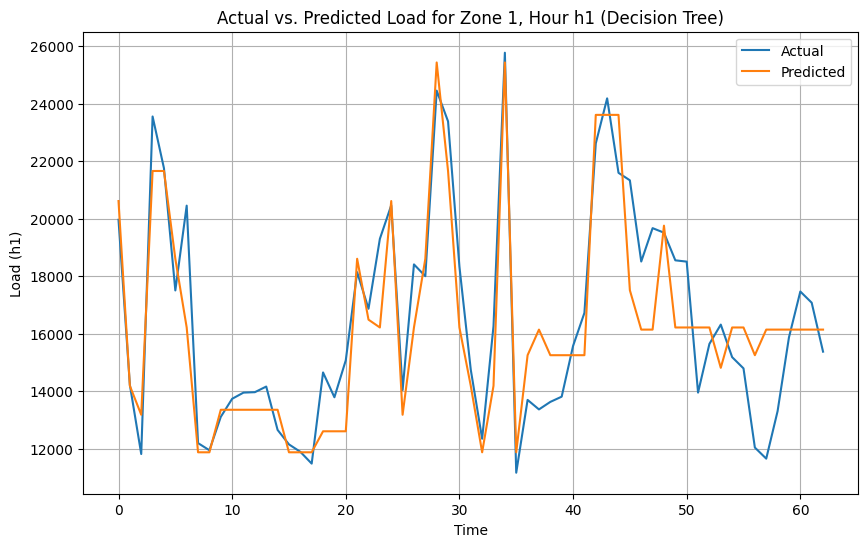

In [8]:
# Plotting Predicted vs Actual for Decision Trees Model

zone_id = 1
hour = 'h1'

# Filter the data for the selected zone
solution_zone = solution[solution['zone_id'] == zone_id]
pred_zone = pred_df[pred_df['zone_id'] == zone_id]

# Extract actual and predicted values for the chosen hour
actual_values = solution_zone[hour].values
predicted_values = pred_zone[hour].values

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predicted_values, label='Predicted')
plt.xlabel('Time')
plt.ylabel(f'Load ({hour})')
plt.title(f'Actual vs. Predicted Load for Zone {zone_id}, Hour {hour} (Decision Tree)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Random Forest

zone_predictions = []

# Define optimized parameter grid for Random Forest
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [10, 20, None],
    'estimator__min_samples_split': [2, 5],
}

n_iter_search = 10
cv_folds = 2

for zone_id in final_data['zone_id'].unique():
    final_data_zone = final_data[final_data['zone_id'] == zone_id]
    solution_zone = solution_new[solution_new['zone_id'] == zone_id]

    # Generate polynomial and interaction terms for train and test data
    for i in range(1, 25):
        final_data_zone[f'temp_h{i}_squared'] = final_data_zone[f'temp_h{i}'] ** 2
        final_data_zone[f'temp_h{i}_day'] = final_data_zone[f'temp_h{i}'] * final_data_zone['day']
        final_data_zone[f'temp_h{i}_month'] = final_data_zone[f'temp_h{i}'] * final_data_zone['month']
        final_data_zone[f'temp_h{i}_hour'] = final_data_zone[f'temp_h{i}'] * i

        solution_zone[f'temp_h{i}_squared'] = solution_zone[f'temp_h{i}'] ** 2
        solution_zone[f'temp_h{i}_day'] = solution_zone[f'temp_h{i}'] * solution_zone['day']
        solution_zone[f'temp_h{i}_month'] = solution_zone[f'temp_h{i}'] * solution_zone['month']
        solution_zone[f'temp_h{i}_hour'] = solution_zone[f'temp_h{i}'] * i

    # Use a random subset of the training data for tuning
    train_sample = final_data_zone.sample(frac=0.5, random_state=42)
    Xtrain_zone = column_transformer.fit_transform(train_sample[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                                 [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                                 [f'temp_h{i}_day' for i in range(1, 25)] +
                                                                 [f'temp_h{i}_month' for i in range(1, 25)] +
                                                                 [f'temp_h{i}_hour' for i in range(1, 25)]])
    Ytrain_zone = train_sample[['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
                                'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
                                'h19', 'h20', 'h21', 'h22', 'h23', 'h24']]

    # Fit the transformer on the full zone data for final training
    Xfull_train = column_transformer.transform(final_data_zone[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                              [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                              [f'temp_h{i}_day' for i in range(1, 25)] +
                                                              [f'temp_h{i}_month' for i in range(1, 25)] +
                                                              [f'temp_h{i}_hour' for i in range(1, 25)]])
    Yfull_train = final_data_zone[['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
                                   'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
                                   'h19', 'h20', 'h21', 'h22', 'h23', 'h24']]

    Xtest_zone = column_transformer.transform(solution_zone[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                           [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                           [f'temp_h{i}_day' for i in range(1, 25)] +
                                                           [f'temp_h{i}_month' for i in range(1, 25)] +
                                                           [f'temp_h{i}_hour' for i in range(1, 25)]])

    # Use RandomizedSearchCV for hyperparameter tuning
    rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    random_search = RandomizedSearchCV(rf, param_distributions=param_grid, scoring='neg_mean_squared_error',
                                       n_iter=n_iter_search, cv=cv_folds, verbose=0, n_jobs=-1, random_state=42)
    random_search.fit(Xtrain_zone, Ytrain_zone)

    print(f"Best hyperparameters for zone {zone_id}: {random_search.best_params_}")

    # Fit the model and predict on the test data
    best_rf = random_search.best_estimator_
    best_rf.fit(Xfull_train, Yfull_train)
    Ypred_zone = best_rf.predict(Xtest_zone)
    Ypred_zone = np.clip(Ypred_zone.astype(int), a_min=0, a_max=None)

    solution_zone = solution_zone[['year', 'month', 'day', 'zone_id']]
    pred_zone_df = pd.DataFrame(Ypred_zone, columns=[f'h{i}' for i in range(1, 25)])
    pred_zone_df = pd.concat([solution_zone.reset_index(drop=True), pred_zone_df], axis=1)
    zone_predictions.append(pred_zone_df)

pred_df = pd.concat(zone_predictions).sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

# Finding loads at the system level (i.e. zone 21)
for i in range(0, len(pred_df), 20):
    zone_21_sum = pred_df.iloc[i:i + 20, 4:].sum()
    zone_21_row = pred_df.iloc[i].copy()
    zone_21_row['zone_id'] = 21
    zone_21_row.iloc[4:] = zone_21_sum
    pred_df = pd.concat([pred_df, pd.DataFrame([zone_21_row])], ignore_index=True)

pred_df = pred_df.sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

pred_df.to_csv("predictions_all_zones_rf_optimized_with_poly.csv", index=False)

# Calculate Weighted Root Mean Square Error (WRMSE)
w = solution['weight'].values
squared_errors = (solution.drop(['year', 'month', 'day', 'zone_id', 'id', 'weight'], axis=1).values.flatten() -
                  pred_df.drop(['year', 'month', 'day', 'zone_id'], axis=1).values.flatten()) ** 2
w_repeated = np.repeat(w, 24)
weighted_squared_errors = squared_errors * w_repeated
wrmse = np.sqrt(weighted_squared_errors.sum() / w_repeated.sum())
print(f'Overall Weighted Root Mean Squared Error (WRMSE): {wrmse}')


Best hyperparameters for zone 1: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__max_depth': 20}
Best hyperparameters for zone 2: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__max_depth': 20}
Best hyperparameters for zone 3: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__max_depth': 20}
Best hyperparameters for zone 4: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 5, 'estimator__max_depth': 20}
Best hyperparameters for zone 5: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__max_depth': 20}
Best hyperparameters for zone 6: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__max_depth': 20}
Best hyperparameters for zone 7: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__max_depth': 20}
Best hyperparameters for zone 8: {'estimator__n_estimators': 200, 'estimator__min_samples_split':

In [ ]:
# XGBoost

zone_predictions = []

# Optimized parameter grid for XGBoost
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

n_iter_search = 20
cv_folds = 3

# Looping through each zone to predict loads separately
for zone_id in final_data['zone_id'].unique():
    final_data_zone = final_data[final_data['zone_id'] == zone_id]
    solution_zone = solution_new[solution_new['zone_id'] == zone_id]

    # Generate polynomial and interaction terms for train and test data
    for i in range(1, 25):
        final_data_zone[f'temp_h{i}_squared'] = final_data_zone[f'temp_h{i}'] ** 2
        final_data_zone[f'temp_h{i}_day'] = final_data_zone[f'temp_h{i}'] * final_data_zone['day']
        final_data_zone[f'temp_h{i}_month'] = final_data_zone[f'temp_h{i}'] * final_data_zone['month']
        final_data_zone[f'temp_h{i}_hour'] = final_data_zone[f'temp_h{i}'] * i

        solution_zone[f'temp_h{i}_squared'] = solution_zone[f'temp_h{i}'] ** 2
        solution_zone[f'temp_h{i}_day'] = solution_zone[f'temp_h{i}'] * solution_zone['day']
        solution_zone[f'temp_h{i}_month'] = solution_zone[f'temp_h{i}'] * solution_zone['month']
        solution_zone[f'temp_h{i}_hour'] = solution_zone[f'temp_h{i}'] * i

    # Use a random subset of the training data for tuning
    train_sample = final_data_zone.sample(frac=0.5, random_state=42)
    Xtrain_zone = column_transformer.fit_transform(train_sample[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                                 [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                                 [f'temp_h{i}_day' for i in range(1, 25)] +
                                                                 [f'temp_h{i}_month' for i in range(1, 25)] +
                                                                 [f'temp_h{i}_hour' for i in range(1, 25)]])
    Ytrain_zone = train_sample[['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
                                'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
                                'h19', 'h20', 'h21', 'h22', 'h23', 'h24']]

    # Fit the transformer on the full zone data for final training
    Xfull_train = column_transformer.transform(final_data_zone[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                              [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                              [f'temp_h{i}_day' for i in range(1, 25)] +
                                                              [f'temp_h{i}_month' for i in range(1, 25)] +
                                                              [f'temp_h{i}_hour' for i in range(1, 25)]])
    Yfull_train = final_data_zone[['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
                                   'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
                                   'h19', 'h20', 'h21', 'h22', 'h23', 'h24']]

    Xtest_zone = column_transformer.transform(solution_zone[['zone_id', 'month', 'day', 'year'] + temperature_columns +
                                                           [f'temp_h{i}_squared' for i in range(1, 25)] +
                                                           [f'temp_h{i}_day' for i in range(1, 25)] +
                                                           [f'temp_h{i}_month' for i in range(1, 25)] +
                                                           [f'temp_h{i}_hour' for i in range(1, 25)]])
    # Use RandomizedSearchCV for hyperparameter tuning
    xgb = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
    random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, scoring='neg_mean_squared_error',
                                       n_iter=n_iter_search, cv=cv_folds, verbose=0, n_jobs=-1, random_state=42)
    random_search.fit(Xtrain_zone, Ytrain_zone)

    print(f"Best hyperparameters for zone {zone_id}: {random_search.best_params_}")

    # Fit the model and predict on the test data
    best_xgb = random_search.best_estimator_
    best_xgb.fit(Xfull_train, Yfull_train)
    Ypred_zone = best_xgb.predict(Xtest_zone)
    Ypred_zone = np.clip(Ypred_zone.astype(int), a_min=0, a_max=None)

    solution_zone = solution_zone[['year', 'month', 'day', 'zone_id']]
    pred_zone_df = pd.DataFrame(Ypred_zone, columns=[f'h{i}' for i in range(1, 25)])
    pred_zone_df = pd.concat([solution_zone.reset_index(drop=True), pred_zone_df], axis=1)
    zone_predictions.append(pred_zone_df)

pred_df = pd.concat(zone_predictions).sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

# Finding loads at the system level (i.e., zone 21)
for i in range(0, len(pred_df), 20):
    zone_21_sum = pred_df.iloc[i:i + 20, 4:].sum()
    zone_21_row = pred_df.iloc[i].copy()
    zone_21_row['zone_id'] = 21
    zone_21_row.iloc[4:] = zone_21_sum
    pred_df = pd.concat([pred_df, pd.DataFrame([zone_21_row])], ignore_index=True)

pred_df = pred_df.sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

pred_df.to_csv("predictions_all_zones_xgb_optimized.csv", index=False)

# Calculate Weighted Root Mean Square Error (WRMSE)
w = solution['weight'].values
squared_errors = (solution.drop(['year', 'month', 'day', 'zone_id', 'id', 'weight'], axis=1).values.flatten() -
                  pred_df.drop(['year', 'month', 'day', 'zone_id'], axis=1).values.flatten()) ** 2
w_repeated = np.repeat(w, 24)
weighted_squared_errors = squared_errors * w_repeated
wrmse = np.sqrt(weighted_squared_errors.sum() / w_repeated.sum())
print(f'Overall Weighted Root Mean Squared Error (WRMSE): {wrmse}')


Best hyperparameters for zone 1: {'estimator__subsample': 0.8, 'estimator__n_estimators': 200, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 1.0}
Best hyperparameters for zone 2: {'estimator__subsample': 0.8, 'estimator__n_estimators': 50, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 0.8}
Best hyperparameters for zone 3: {'estimator__subsample': 0.8, 'estimator__n_estimators': 50, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 0.8}
Best hyperparameters for zone 4: {'estimator__subsample': 0.8, 'estimator__n_estimators': 50, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 0.8}
Best hyperparameters for zone 5: {'estimator__subsample': 0.8, 'estimator__n_estimators': 200, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 1.0}
Best hyperparameters for zone 6: {'estimator__su

#### LSTM Network

In [ ]:
# Re-processing the data: merging temperature data from all 11 stations to improve the LSTM's flexibility

def create_final_data_all_temp(final_data, temp_hist):
    # Drop the existing temperature columns
    final_data = final_data.drop(columns=[
        'station_id'] + [f'temp_h{i}' for i in range(1, 25)]
    )

    # Melt temp_hist to long format for merging
    temp_hist_long = temp_hist.melt(
        id_vars=['station_id', 'year', 'month', 'day'],
        var_name='hour',
        value_name='temperature'
    )

    temp_hist_long['hour'] = temp_hist_long['hour'].str.extract(r'h(\d+)').astype(int)
    temp_hist_long['temp_col'] = temp_hist_long['station_id'].astype(str) + '_hour' + temp_hist_long['hour'].astype(str)

    # Pivot to wide format
    temp_hist_wide = temp_hist_long.pivot_table(
        index=['year', 'month', 'day'],
        columns='temp_col',
        values='temperature'
    ).reset_index()

    # Merge with final_data
    final_data_all_temp = pd.merge(
        final_data,
        temp_hist_wide,
        on=['year', 'month', 'day'],
        how='left'
    )

    return final_data_all_temp

def create_solution_new_all_temp(solution_new, temp_hist):
    # Drop the existing temperature columns
    solution_new = solution_new.drop(columns=[
        'station_id'] + [f'temp_h{i}' for i in range(1, 25)]
    )

    # Melt temp_hist to long format for merging
    temp_hist_long = temp_hist.melt(
        id_vars=['station_id', 'year', 'month', 'day'],
        var_name='hour',
        value_name='temperature'
    )

    temp_hist_long['hour'] = temp_hist_long['hour'].str.extract(r'h(\d+)').astype(int)
    temp_hist_long['temp_col'] = temp_hist_long['station_id'].astype(str) + '_hour' + temp_hist_long['hour'].astype(str)

    # Pivot to wide format
    temp_hist_wide = temp_hist_long.pivot_table(
        index=['year', 'month', 'day'],
        columns='temp_col',
        values='temperature'
    ).reset_index()

    # Merge for weights 1 or 20
    forecast_mask = solution_new['weight'].isin([8, 160])
    historical_mask = ~forecast_mask

    # Historical entries: merge with temp_hist_wide
    solution_new_all_temp = solution_new[historical_mask].merge(
        temp_hist_wide,
        on=['year', 'month', 'day'],
        how='left'
    )

    # Forecasting entries: average temperature across all previous years
    temp_hist_wide_avg = temp_hist_wide.groupby(['month', 'day']).mean().reset_index()
    temp_hist_wide_avg = temp_hist_wide_avg.drop(columns=['year'], errors='ignore')

    forecast_entries = solution_new[forecast_mask].merge(
        temp_hist_wide_avg,
        on=['month', 'day'],
        how='left'
    )

    solution_new_all_temp = pd.concat([solution_new_all_temp, forecast_entries], ignore_index=True)

    return solution_new_all_temp

# Create the transformed dataframes
final_data_all_temp = create_final_data_all_temp(final_data, temp_hist)
solution_new_all_temp = create_solution_new_all_temp(solution_new, temp_hist)

# Reorder solution_new_all_temp to match the order of solution_new's ids
solution_new_all_temp = solution_new_all_temp.set_index('id').reindex(solution_new['id']).reset_index()

final_data_all_temp.to_csv("final_data_all_temp.csv", index=False)
solution_new_all_temp.to_csv("solution_new_all_temp.csv", index=False)


In [ ]:
# Implementing LSTM with the newly processed data

# Set random seed for reproducibility
SEED = 4321
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

zone_predictions = []

# Define hyperparameter grid for randomized search
param_distributions = {
    'units': [50, 100, 200],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [16, 32, 64],
    'epochs': [20, 40, 60],
    'optimizer': ['adam', 'rmsprop']
}

# Define the hybrid LSTM model
def build_hybrid_model(input_dim, output_dim, units, activation, dropout_rate, optimizer):
    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(1, input_dim)))
    model.add(LSTM(units, activation=activation, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim))
    model.compile(optimizer=optimizer, loss=Huber(delta=1.0))
    return model

for zone_id in final_data_all_temp['zone_id'].unique():
    print(f"Processing zone: {zone_id}")
    final_data_zone = final_data_all_temp[final_data_all_temp['zone_id'] == zone_id].copy()
    solution_zone = solution_new_all_temp[solution_new_all_temp['zone_id'] == zone_id].copy()

    # Incorporate hour as a feature for each time-step
    final_data_zone['hour'] = np.arange(1, len(final_data_zone) + 1) % 24
    final_data_zone['hour'] = final_data_zone['hour'].replace(0, 24)

    solution_zone['hour'] = np.arange(1, len(solution_zone) + 1) % 24
    solution_zone['hour'] = solution_zone['hour'].replace(0, 24)

    # Prepare training and testing datasets
    temp_columns = [f'{i}_hour{j}' for i in range(1, 12) for j in range(1, 25)]
    Xtrain_zone = final_data_zone[['month', 'day', 'hour'] + temp_columns].fillna(0).to_numpy()
    Ytrain_zone = final_data_zone[[f'h{i}' for i in range(1, 25)]].fillna(0).to_numpy()

    Xtest_zone = solution_zone[['month', 'day', 'hour'] + temp_columns].fillna(0).to_numpy()

    # Scale the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    Xtrain_zone_scaled = scaler_x.fit_transform(Xtrain_zone)
    Xtest_zone_scaled = scaler_x.transform(Xtest_zone)
    Ytrain_zone_scaled = scaler_y.fit_transform(Ytrain_zone)

    Xtrain_zone_scaled = Xtrain_zone_scaled.reshape(-1, 1, Xtrain_zone_scaled.shape[1])
    Xtest_zone_scaled = Xtest_zone_scaled.reshape(-1, 1, Xtest_zone_scaled.shape[1])

    # Perform hyperparameter tuning
    best_model, best_params, best_loss = None, None, float('inf')
    param_combinations = list(ParameterSampler(param_distributions, n_iter=10, random_state=42))
    for params in param_combinations:
        model = build_hybrid_model(
            input_dim=Xtrain_zone_scaled.shape[2],
            output_dim=Ytrain_zone_scaled.shape[1],
            units=params['units'],
            activation=params['activation'],
            dropout_rate=params['dropout_rate'],
            optimizer=params['optimizer']
        )
        early_stopping = EarlyStopping(monitor='loss', patience=5)
        model.fit(Xtrain_zone_scaled, Ytrain_zone_scaled, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        loss = model.evaluate(Xtrain_zone_scaled, Ytrain_zone_scaled, verbose=0)
        if loss < best_loss:
            best_model, best_params, best_loss = model, params, loss

    print(f"Best parameters for zone {zone_id}: {best_params}")

    # Predict on test data
    Ypred_zone_scaled = best_model.predict(Xtest_zone_scaled)
    Ypred_zone = scaler_y.inverse_transform(Ypred_zone_scaled)
    Ypred_zone = np.clip(Ypred_zone.astype(int), a_min=0, a_max=None)

    solution_zone = solution_zone[['year', 'month', 'day', 'zone_id']]
    pred_zone_df = pd.DataFrame(Ypred_zone, columns=[f'h{i}' for i in range(1, 25)])
    pred_zone_df = pd.concat([solution_zone.reset_index(drop=True), pred_zone_df], axis=1)
    zone_predictions.append(pred_zone_df)

pred_df = pd.concat(zone_predictions).sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

# Adding system-wide loads (zone 21)
zone_21_rows = []
numeric_columns = [f'h{i}' for i in range(1, 25)]

for i in range(0, len(pred_df), 20):  # Assuming 20 zones per group
    zone_21_sum = pred_df.iloc[i:i + 20][numeric_columns].sum()
    zone_21_row = pred_df.iloc[i][['year', 'month', 'day']].to_dict()
    zone_21_row['zone_id'] = 21
    for col in numeric_columns:
        zone_21_row[col] = zone_21_sum[col]
    zone_21_rows.append(zone_21_row)

zone_21_df = pd.DataFrame(zone_21_rows)
lstm_predictions = pd.concat([pred_df, zone_21_df], ignore_index=True).sort_values(by=['year', 'month', 'day', 'zone_id']).reset_index(drop=True)

lstm_predictions.to_csv("predictions_all_zones_hybrid_lstm.csv", index=False)

# Calculate Weighted Root Mean Square Error (WRMSE)
w = solution['weight'].values
squared_errors = (solution.drop(['year', 'month', 'day', 'zone_id', 'id', 'weight'], axis=1).values.flatten() -
                  lstm_predictions.drop(['year', 'month', 'day', 'zone_id'], axis=1).values.flatten()) ** 2
w_repeated = np.repeat(w, 24)
weighted_squared_errors = squared_errors * w_repeated
wrmse = np.sqrt(weighted_squared_errors.sum() / w_repeated.sum())
print(f'Overall Weighted Root Mean Squared Error (WRMSE): {wrmse}')


Processing zone: 1
Best parameters for zone 1: {'units': 50, 'optimizer': 'adam', 'epochs': 40, 'dropout_rate': 0.2, 'batch_size': 64, 'activation': 'relu'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Processing zone: 2
Best parameters for zone 2: {'units': 200, 'optimizer': 'rmsprop', 'epochs': 40, 'dropout_rate': 0.2, 'batch_size': 64, 'activation': 'relu'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Processing zone: 3
Best parameters for zone 3: {'units': 200, 'optimizer': 'rmsprop', 'epochs': 40, 'dropout_rate': 0.2, 'batch_size': 64, 'activation': 'relu'}


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Processing zone: 4
Best parameters for zone 4: {'units': 200, 'optimizer': 'adam', 'epochs': 60, 'dropout_rate': 0.3, 'batch_size': 32, 'activation': 'tanh'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
Processing zone: 5
Best parameters for zone 5: {'units': 200, 'optimizer': 'adam', 'epochs': 60, 'dropout_rate': 0.3, 'batch_size': 32, 'activation': 'tanh'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Processing zone: 6
Best parameters for zone 6: {'units': 50, 'optimizer': 'adam', 'epochs': 40, 'dropout_rate': 0.2, 'batch_size': 64, 'activation': 'relu'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Processing zone: 7
Best parameters for zone 7: {'units': 100, 'optimizer': 'rmsprop', 'epochs': 60, 'dropout_rate': 0.2, 'batch_size': 16, 'activation': 'tanh'}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Processing zone: 8
Best parameters for zone 8: {'units': 200, 'optimizer': 'adam', 'epochs': 60, 'dropout_rate': 0.3, 'batch_size': 32, 'activation': 'tanh'}
2/2 ━━━━━━━━━

#### Ensemble Methods


In [ ]:
# Creating an ensemble of KNN and LSTM, since they are the best-performing models

# Calculate inverse WRMSE weights and normalize them
lstm_wrmse = 92854
knn_wrmse = 90102

lstm_weight = 1 / lstm_wrmse
knn_weight = 1 / knn_wrmse
total_weight = lstm_weight + knn_weight

lstm_weight /= total_weight
knn_weight /= total_weight

# Perform weighted ensemble
numeric_columns = [f'h{i}' for i in range(1, 25)]
ensemble_predictions = lstm_predictions.copy()
ensemble_predictions[numeric_columns] = (
    lstm_weight * lstm_predictions[numeric_columns] +
    knn_weight * knn_predictions[numeric_columns]
)

ensemble_predictions.to_csv("predictions_all_zones_ensemble.csv", index=False)

# Calculate Weighted Root Mean Square Error (WRMSE) for the ensemble
w = solution['weight'].values
squared_errors = (solution.drop(['year', 'month', 'day', 'zone_id', 'id', 'weight'], axis=1).values.flatten() -
                  ensemble_predictions.drop(['year', 'month', 'day', 'zone_id'], axis=1).values.flatten()) ** 2
w_repeated = np.repeat(w, 24)
weighted_squared_errors = squared_errors * w_repeated
wrmse = np.sqrt(weighted_squared_errors.sum() / w_repeated.sum())
print(f'Overall Weighted Root Mean Squared Error (WRMSE) for Ensemble: {wrmse}')


Overall Weighted Root Mean Squared Error (WRMSE) for Ensemble: 89801.40679080409


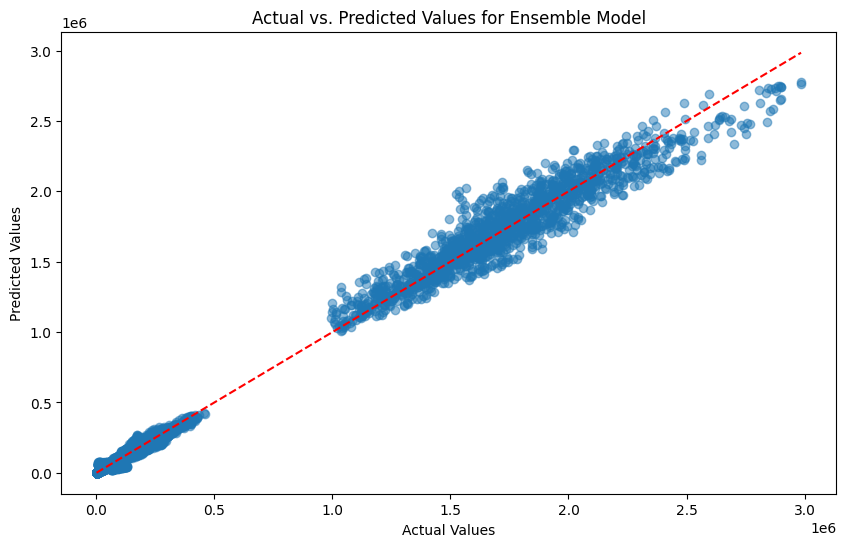

In [ ]:
# Plotting Predicted vs Actual for Ensemble Model

# Reshape the data for plotting
actual_values = solution.drop(['year', 'month', 'day', 'zone_id', 'id', 'weight'], axis=1).values.flatten()
predicted_values = ensemble_predictions.drop(['year', 'month', 'day', 'zone_id'], axis=1).values.flatten()


plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for Ensemble Model")
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--') # Add a diagonal line
plt.show()